In [9]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
import jax.numpy.fft as jfft
from numpy import sqrt

In [10]:
def fft2(x):
    """Applies a 2D FFT over the first two dimensions of the input array x."""
    return fftn(x, axes=(0, 1))

def ifft2(x):
    """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
    return ifftn(x, axes=(0, 1))

In [11]:
def FNOBlock2D(modes):
    def compl_mul2d(input, weights):
        return jnp.einsum("jixy,ikxy->jkxy", input, weights)

    def init_fun(rng, input_shape):
        k1, k2 = random.split(rng)
        W1 = random.normal(k1, (input_shape[1], input_shape[1], modes, modes))
        W2 = random.normal(k2, (input_shape[1], input_shape[1], modes, modes))
        return input_shape, (W1, W2)

    def apply_fun(params, inputs, **kwargs):
        W1, W2 = params
        x_ft = fft2(inputs)
        out_ft = jnp.zeros_like(x_ft)
        out_ft = out_ft.at[:, :, : W1.shape[2], : W1.shape[3]].set(compl_mul2d(x_ft[:, :, : W1.shape[2], : W1.shape[3]], W1))
        out_ft = out_ft.at[:, :, -W2.shape[2] :, : W2.shape[3]].set(compl_mul2d(x_ft[:, :, -W2.shape[2] :, : W2.shape[3]], W2))
        return ifft2(out_ft)

    return init_fun, apply_fun



In [12]:
def Permute(order):
    def permutation_indices(order):
        if order == "ijkl->iljk":
            return (0, 3, 1, 2)
        elif order == "ijkl->iklj":
            return (0, 2, 3, 1)
        else:
            raise NotImplementedError

    def init_fun(rng, input_shape):
        idx = permutation_indices(order)
        output_shape = tuple([input_shape[i] for i in idx])
        return output_shape, ()

    def apply_fun(params, inputs, **kwargs):
        outputs = jnp.einsum(order, inputs)
        return outputs

    return init_fun, apply_fun



In [13]:
@optimizer
def complex_adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = make_schedule(step_size)
    def init(x0):
        m0 = jnp.zeros_like(x0)
        v0 = jnp.zeros_like(x0)
        return x0, m0, v0, jnp.zeros(())
    def update(i, g, state):
        x, m, v, t = state
        t = t + 1
        m = (1 - b1) * g + b1 * m
        v = (1 - b2) * (g * jnp.conj(g)) + b2 * v
        mhat = m / (1 - b1 ** t)
        vhat = v / (1 - b2 ** t)
        step = step_size(i) * mhat / (jnp.sqrt(vhat) + eps)
        x = x - step
        return x, m, v, t
    def get_params(state):
        x, m, v, t = state
        return x
    return init, update, get_params

In [18]:
# def normalize_data(data):
#     """
#     Normalize 2D data to the range [-1, 1].

#     Parameters:
#     data (jnp.ndarray): 2D array to be normalized.

#     Returns:
#     jnp.ndarray: Normalized 2D array.
#     """
#     min_val = jnp.min(data)
#     max_val = jnp.max(data)
#     normalized_data = 2 * (data - min_val) / (max_val - min_val) - 1
#     return normalized_data





In [15]:
class SPiFOL:
    def __init__(self,L, eps, pp2, qq2, dt, h, arch, N, fno_layers, lr, activation, norm_par):
        self.arch = arch
        self.N = N
        self.lr = lr
        self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.h = h
        self.L = L

        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
        else:
            raise ValueError("Unsupported architecture!")

        self.params = params

        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(lr)
        self.opt_state = self.opt_init(self.params)

        # Logging losses
        self.total_loss_log = []

        # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        self.itercount = iter(range(10000))

    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            uk = uk.reshape(-1, self.N, self.N, 1)  # Reshape input strain tensor
            O = self.N_apply(params, uk)  # Apply the FNO network
            O = jnp.real(O)  # Take the real part of the output
            O = O.reshape(self.N, self.N)  # Reshape output
            return O
        else:
            raise ValueError("Unsupported architecture type!")
        
    @partial(jit, static_argnums=(0,))
    def allen_cahn_equation(self, uk):
        cahn = self.eps**2 #cahn number 
        uk = jnp.real(uk)
            # Transforming the solution to the discrete Fourier space
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) # us is the real space
        v_hat = s_hat / (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2)))  # Allen-Cahn equation
        u_k1= jfft.ifft2(v_hat)  # u_k+1 result
        return jnp.real(u_k1)

    @partial(jit, static_argnums=(0,))
    # def laplacian(self, u):
    #     return (jnp.roll(u, 1, axis=0) + jnp.roll(u, -1, axis=0) +
    #             jnp.roll(u, 1, axis=1) + jnp.roll(u, -1, axis=1) - 4 * u) / (self.h ** 2)

    def laplacian(self, u):
        factor = (self.N ** 4) / (self.L ** 2)  # Incorporates h^2 / N^2
        return factor * (jnp.roll(u, 1, axis=0) + jnp.roll(u, -1, axis=0) +
                     jnp.roll(u, 1, axis=1) + jnp.roll(u, -1, axis=1) - 4 * u)

    # @partial(jit, static_argnums=(0,))
    # def nonlinear_term(self, u):
    #     return u ** 3 - u

    def nonlinear_term(self, u):
    # Compute h^2
        h_squared = (self.L / self.N) ** 2
    # Scaling factor
        scaling_factor = h_squared / (self.eps ** 2)
    # Nonlinear term with scaling
        return scaling_factor * (u ** 3 - u)

    # def nonlinear_term(u):
    #     return jnp.power(u, 3) - u

    # grad_nonlinear = grad(nonlinear_term)

    @partial(jit, static_argnums=(0,))
    def total_energy(self, u):
        laplacian_u = self.laplacian(u)
        nonlinear_u = self.nonlinear_term(u)
        energy = 0.5 * jnp.sum(laplacian_u ** 2) + jnp.sum(nonlinear_u)
        return energy

    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk, u_gt):
        u_pred = self.operator_net(params, uk)
        u_pred = u_pred.reshape(self.N, self.N)
        
        # Allen-Cahn equation loss
        energy_loss = self.total_energy(u_pred)
        distance_loss = jnp.mean((u_gt - u_pred) ** 2)
        total_loss = distance_loss + energy_loss
        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk, u_gt):
        params = self.get_params(opt_state)
        grads = grad(self.loss_single)(params, uk, u_gt)
        return self.opt_update(i, grads, opt_state)

    def train(self, uk, nIter=10000):
        u_gt = self.allen_cahn_equation(uk) #gt is ground truth
        pbar = trange(nIter)

        for it in pbar:
            self.opt_state = self.step(next(self.itercount), self.opt_state, uk, u_gt)

            # Logger (log the loss every 100 iterations)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_single(params, uk, u_gt)
                self.total_loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s, Loss=3.5954688e+20]


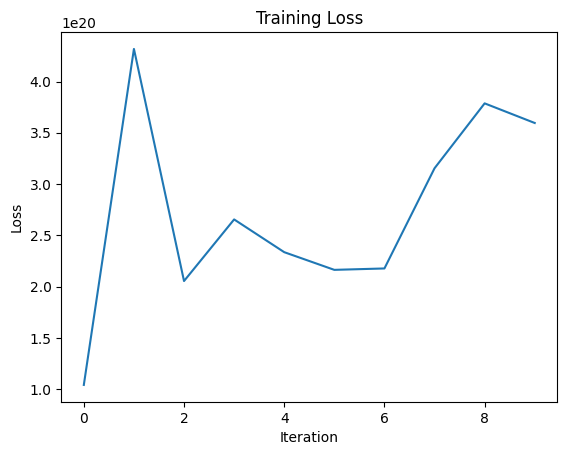

In [16]:
# Parameters

N = 128 # no. of grid point
eps = 0.05
lr = 0.001
L = 2.0 * jnp.pi                                    
h = L / N 
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 20 #number of snapshots



# Generate input condition
xx, yy = jnp.meshgrid(jnp.linspace(-0.5*L+h,0.5*L,N), jnp.linspace(-0.5*L+h,0.5*L,N))
input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2) * eps)
input_condition = normalize_data(input_condition)

# # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])


# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
# #print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# Define FNO layers
fno_layers = [
    Dense(32),
    Permute("ijkl->iljk"),
    FNOBlock2D(32),
    Gelu,  # activation can be changed here
    FNOBlock2D(32),
    Gelu,
    FNOBlock2D(32),
    Permute("ijkl->iklj"),
    Dense(128),
    Gelu,
    Dense(1),
]

# Initialize and train the model
model = SPiFOL(L, eps, pp2, qq2, dt, h, arch='FNO', N=N, fno_layers=fno_layers, lr=lr, activation=jax.nn.relu, norm_par=1000.0)
model.train(input_condition, nIter=1000)

# params = model.get_params(model.opt_state)
# model_prediction = model.operator_net(params, input_condition).reshape(N, N)

# Plot the figures
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# contour_levels = 20
# axs[0].contour(xx,yy, jnp.real(input_condition.T),levels=[0], colors="green")
# axs[0].set_title('Input Condition')
# axs[0].axis('off')
# axs[0].set_aspect('equal', adjustable='box')
# # plt.gca().set_aspect('equal', adjustable='box') 

# # Plot model prediction
# # axs[1].contour(xx,yy, jnp.real(input_condition_i.T),levels=[0], colors="green")

# axs[1].contour(xx, yy, jnp.real(model_prediction.T), levels=[0], colors="red")
# axs[1].set_title('Model Prediction')
# axs[1].axis('off')
# axs[1].set_aspect('equal', adjustable='box')


# # Plot loss
# axs[2].plot(model.total_loss_log)
# axs[2].set_title('Training Loss')
# axs[2].set_xlabel('Iteration')
# axs[2].set_ylabel('Loss')

# plt.tight_layout()
# plt.show()

# Plot the loss
plt.plot(model.total_loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [17]:
# # difinning the no of grid points in x, y and z
# Nx = 128 # number of grid points in x be positive even integer number
# Ny = 128 # number of grid points in y be positive even integer number




# # Define the parameters of the Allen-Cahn equation in 2d
# Lx = 2.0 * jnp.pi #length of the domain in x
# Ly = 2.0 * jnp.pi #length of the domain in y
# hx = Lx / Nx #spatial step size in coordinate x
# hy = Ly / Ny #spatial step size in coordinate y
# print(f'hx ko size = {hx}')
# dt = 0.0001 #time step size
# T = 4 #final time
# Nt = int(jnp.round(T/dt)) #number of time steps
# ns = Nt / 20 #number of snapshots

# # Define the grid points in x and y direction
# def x_gridpoint(Nx, Lx, hx):
#     x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
#     return x
# x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
# def y_gridpoint(Ny, Ly, hy):
#     y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
#     return y
# y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# # creating meshgrid in x and y direction
# xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# # defining parameters for the Allen-Cahn equation
# epsillon = 0.05 #small parameter
# cahn = epsillon**2 #cahn number  

# # initial condition of allen cahn equation
# u =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation
# # theta = jnp.arctan(y/x)
# # u =jnp.tanh((1.7 - 1.2 * jnp.cos(6*theta) - sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))


# # defining the wavenumber in x and y direction , which is in fourier space
# p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
# q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# # square of wavenumber in x and y direction
# p2 = p**2 # square of wavenumber in x direction
# q2 = q**2 # square of wavenumber in y direction

# # creating meshgrid in x and y direction for square of wavenumber
# pp2, qq2 = jnp.meshgrid(p2, q2)
# #print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# # # plotting the initial condition of the Allen-Cahn equation

# # figure1 = plt.figure()
# # plt.contour(x, y, jnp.real(u.T), [0])
# # plt.gca().set_aspect('equal', adjustable='box') 
# # plt.title('Initial condition')
# # plt.xlabel('x')
# # plt.ylabel('y')
# # plt.show()



# # # # providing the range of iteration

# # for iter in range(1, Nt):
# #     u = jnp.real(u)
# #     # print(f'real space u ko size ={u.shape}')
# #     # Transforming the solution to the discrete Fourier space
# #     s_hat = jfft.fft2(cahn * u - dt * (u**3 - 3 * u)) # us is the real space
# #     # print(f's_hat ko size = {s_hat.shape}')
# #     v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))  # Allen-Cahn equation
# #     u = jfft.ifft2(v_hat)  # u_k+1 result
# #     # print(f'inverse u ko size = {u.shape}')
    

# #     if iter % ns == 0:
# #         plt.contour(x, y, jnp.real(u.T), [0], colors='red')
# #         plt.gca().set_aspect('equal', adjustable='box') 
    
# # plt.title('Numerical Solutions after iteration ' + str(Nt))
# # plt.show()





## loss calculation copy from data_generation file to run the code

100%|██████████| 1000/1000 [26:34<00:00,  1.59s/it, Loss=0.0018420698]


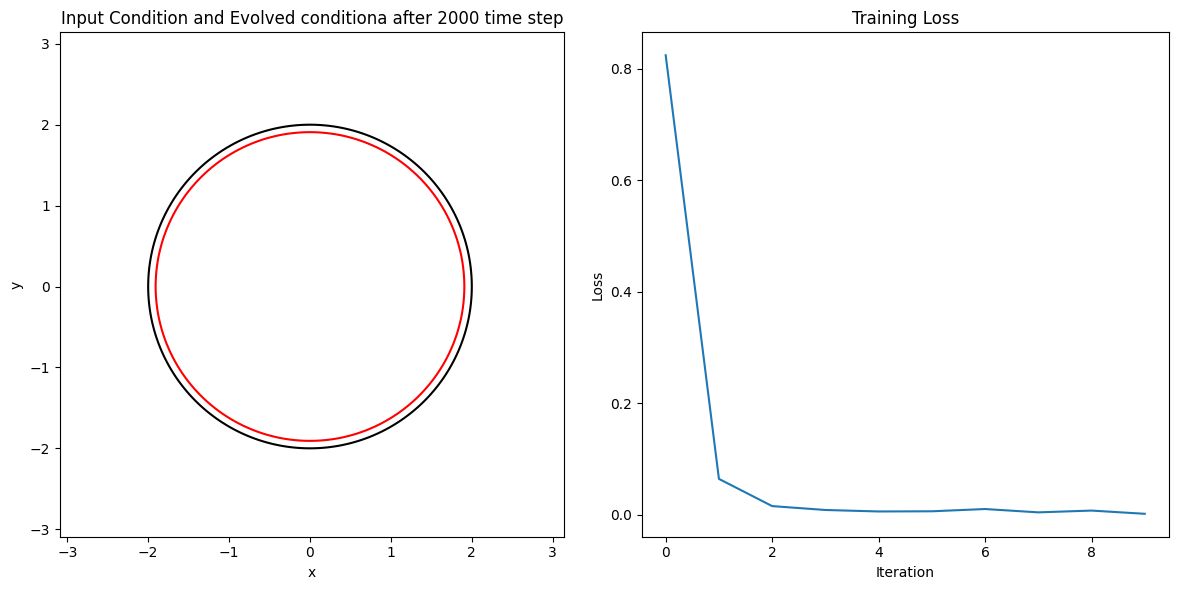

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP




def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))




# Define normalization and denormalization functions
def normalize(data):
   mean = jnp.mean(data)
   std = jnp.std(data)
   return (data - mean) / std, mean, std


def denormalize(data, mean, std):
   return data * std + mean



class SPiFOL:
   def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
       self.arch = arch
       self.N = N
       self.lr = lr
       # self.norm_par = norm_par
       self.eps = eps
       self.pp2 = pp2
       self.qq2 = qq2
       self.dt = dt
       self.L = L
       self.h = h
       self.x = x
       self.y = y
       # Initialize the network based on architecture type
       if arch == 'FNO':
           self.N_init, self.N_apply = serial(*fno_layers)
           _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
          
       elif arch == 'MLP':
           self.N_init, self.N_apply = MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
          
       elif arch == 'modified_MLP':
           self.N_init, self.N_apply = modified_MLP(mlp_layers)
           params = self.N_init(random.PRNGKey(1234))
       else:
           raise ValueError("Unsupported architecture!")


       self.params = params


    
       # Optimizer setup
       self.opt_init, self.opt_update, self.get_params = complex_adam(
           jax.example_libraries.optimizers.exponential_decay(
               lr, decay_steps=2000, decay_rate=0.9)
           )
      
       self.opt_state = self.opt_init(self.params)


       # Logging losses
       self.total_loss_log = []
       self.total_energy_loss_log = []


       # Initialize optimizer state
       self.opt_state = self.opt_init(self.params)
       self.itercount = iter(range(50000))


   @partial(jit, static_argnums=(0,))
   def operator_net(self, params, uk):
       if self.arch == 'FNO':
           uk = uk.reshape(-1, self.N, self.N, 1)  # Reshape input 
           O = self.N_apply(params, uk)  # Apply the FNO network
           O = jnp.real(O)  # Take the real part of the output
           O = O.reshape(self.N, self.N)  # Reshape output
           return O
       elif self.arch == 'MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)  # Directly apply the network
           O = O.reshape(self.N, self.N)  # Reshape output to match strain components
           # O = O / self.norm_par  # Normalize the output
           return O
       elif self.arch == 'modified_MLP':
           uk = uk.flatten()
           O = self.N_apply(params, uk)
           O = O.reshape(self.N, self.N)
           return O
       else:
           raise ValueError("Unsupported architecture type!")
      

   def allen_cahn_equation(self, uk, total_steps=2000):
        for _ in range(total_steps):
            cahn = eps**2
            uk = jnp.real(uk)
            # Allen-Cahn equation in Fourier space
            s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))
            v_hat = s_hat / (cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2)))
            uk = jfft.ifft2(v_hat)  # Update uk to the next state
        # uk = np.load('final_output.npy_20000.npy')
            # print(f'shree is my heart')

        return jnp.real(uk)  # Return only the final state
   

   @partial(jit, static_argnums=(0,))
   def loss_single(self, params, uk):
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N)
        u_ac = self.allen_cahn_equation(uk)
        
        # Allen-Cahn equation loss
    #    energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
    #    total_loss = distance_loss + energy_loss
        return datadriven_loss
   

   @partial(jit, static_argnums=(0,))
   def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_single)(params, uk)
        return self.opt_update(i, grads, opt_state)


   def train(self, uk, nIter=1000):
        pbar = trange(nIter)
        for it in pbar:
            self.opt_state = self.step(next(self.itercount), self.opt_state, uk)
    #    self.itercount = iter(range(nIter))  # Create an iterator
            



            # Logger (log the loss every 100 iterations)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_single(params, uk)
                self.total_loss_log.append(loss)
                # self.total_energy_loss_log.append(energy_loss)
                pbar.set_postfix({'Loss': loss})


# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.1 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)

 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)


# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(32),
#    Permute("ijkl->iljk"),
#    FNOBlock2D(32),
   Gelu,  # activation can be changed here
#    FNOBlock2D(32),
#    Gelu,
#    FNOBlock2D(32),
#    Permute("ijkl->iklj"),
   Dense(32),
   Gelu,
   Dense(1),
]



cahn = eps**2
for arch in arch_list:
   # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers,mlp_layers,lr, arch)
    # final_state = model.allen_cahn_equation(input_condition)
    model.train(input_condition, nIter=1000)


params = model.get_params(model.opt_state)
model_prediction = model.operator_net(params, input_condition).reshape(N, N)



# Plot the initial and final states
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Input condition plot
axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="black")
axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="red")

axs[0].set_title('Input Condition and Evolved conditiona after 2000 time step')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


# #    # Plot loss
axs[1].plot(model.total_loss_log)
axs[1].set_title('Training Loss')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')






plt.tight_layout()
plt.show()

            

## this cell for average the error 

In [ ]:
from haiku import Flatten
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
import tensorflow as tf
from tensorflow.keras import layers
from jax.nn import relu, tanh
from sklearn.metrics import r2_score, mean_squared_error








def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))


class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=20, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u  # Input samples
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key
        self.current_idx = 0  # Track the current index for iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    def __len__(self):
        'Return the number of batches'
        return self.N // self.batch_size  # Total full batches

    def __iter__(self):
        'Return an iterator that resets itself'
        self.current_idx = 0  # Reset the index
        return self

    def __next__(self):
        'Get the next batch'
        if self.current_idx >= len(self):  # Stop when all batches are processed
            raise StopIteration
        self.current_idx += 1
        return self.__getitem__(self.current_idx)

    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx, :]
        return u





class SPiFOL:
    def __init__( self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        
       

        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y

      


    
        
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 3))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)


        # Logging losses
        self.train_losses = []
        # self.total_energy_loss_log = []
        self.test_losses = []  # Initialize list to track test losses



        # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        self.itercount = iter(range(50000))

    # def add(self, layer):
    #     """Dynamically add a layer to the model."""
    #     self.layers_list.append(layer)
        
    # def call(self, inputs):
    #     """Forward pass: Apply each layer to the input sequentially."""
    #     x = inputs
    #     for layer in self.layers_list:
    #         x = layer(x)
    #     return x

    
        
     

    # @jax.jit
    def normalize(self,data):
        min_val = jnp.min(data, axis=(0, 1))
        max_val = jnp.max(data, axis=(0, 1))
        range_val = max_val - min_val
        range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
        normalized_data = 2 * (data - min_val) / range_val - 1
        return normalized_data

    
    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            print(f'uk ko shape before reshape inside operator net.{uk.shape}')
        #    uk = uk.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape input 
            input_FNO = uk.reshape(-1, self.N, self.N, 3)  # Reshape for FNO
            print(f'input_fno ko shape after reshape .{input_FNO.shape}')

            
            print("Calling self.N_apply now...")

            O = self.N_apply(params, input_FNO)  # Apply the FNO network
            print("self.N_apply executed successfully!")

        #    O = jnp.real(O)  # Take the real part of the output
            O = O.reshape(self.N, self.N, 3)  # Reshape output
            print(f'o ko shape after reshape.{O.shape}')


            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            # O = O / self.norm_par  # Normalize the output
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    def allen_cahn_equation(self, uk, total_steps=500):
        # debug.print("Processing x")  # Prints each x correctly
        print(f'uk ko shape as input:{uk.shape}')

            # Expand pp2 and qq2 to include a channel dimension
        self.pp2 = jnp.expand_dims(self.pp2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        self.qq2 = jnp.expand_dims(self.qq2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
        print(f'pp2 shape after expanding: {self.pp2.shape}')  # Expected: (1, 128, 128, 1)


        # Broadcast pp2 and qq2 to match the shape of uk
        self.pp2 = jnp.broadcast_to(self.pp2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        self.qq2 = jnp.broadcast_to(self.qq2, (1, self.N, self.N, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
        print(f'pp2 shape after broadcasting: {self.pp2.shape}')  # Expected: (1, 128, 128, 3)

        # for _ in range(total_steps):

        cahn = eps**2
        uk = jnp.real(uk)
        # print(f'uk ko shape as input:{uk.shape}')

        # Check shapes for debugging
        # print(f"pp2 shape after broadcasting: {self.pp2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"qq2 shape after broadcasting: {self.qq2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (1, 128, 128, 3)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))  # Shape: (1, 128, 128, 3)
        # print(f"denominator shape: {denominator.shape}")  # Expected: (1, 128, 128, 3)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk))  # Shape: (1, 128, 128, 3)
        v_hat = s_hat / denominator  # Shape: (1, 128, 128, 3)
        uk = jfft.ifft2(v_hat)  # Shape: (1, 128, 128, 3)
        uk = uk.reshape(self.N, self.N, 3)
        print(f'uk size after allen cahn {uk.shape}')

        

        return jnp.real(uk) # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # print(f'[uk ko shape on loss single : {uk.shape}')

        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 3)
        # print(f'[u_nn ko shape on loss single : {u_nn.shape}')
        print(f'Shape of predictions (u_nn): {u_nn.shape}')
       


        u_ac = self.allen_cahn_equation(uk)

        print("Shape of predictions:", u_nn.shape)
        print("Shape of y (ground truth):", u_ac.shape)

        
        # Allen-Cahn equation loss
        # energy_loss = self.total_energy(u_pred)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)  # this is the mean square error
        # total_loss = datadriven_loss + energy_loss
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
        # print(f' batch ko size : {batch.shape}')
        # batch losses
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        # debug.print(f'size of batch loss after vmap={batch_loss.shape}')  # Prints each x correctly

        batch_loss  = jnp.mean(batch_loss)
        
        return batch_loss
    
    @jit  # JIT compilation for faster execution
    def accuracy( self, u_nn, u_ac):
        # Reshape to 2D (batch_size, flattened grid)
        u_pred = jnp.reshape(u_nn, (-1, self.N * self.N *3))
        u_true = jnp.reshape(u_ac, (-1, self.N * self.N * 3))
        
        # Compute R² Score (variance explained) using sklearn
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))

        # Compute Mean Squared Error (MSE) using sklearn
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))

        # Compute L₂ Relative Error (normalized error) using JAX
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)
        
        return r2, l2_rel



    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        # print(f'uk ko shape before step:{uk.shape}')
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of the SPiFOL class
    def train(self, data_train, num_epochs=1):
        # print(f'data_train ko shape:{data_train[0].shape}')
        # Example training loop
        pbar = trange(num_epochs)
        for it in pbar:
            for batch_idx, batch in enumerate(data_train):
                self.opt_state = self.step(batch_idx, self.opt_state, batch)
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                self.train_losses.append(loss)
                pbar.set_postfix({ 'Epoch': it+1, 'Batch': batch_idx+1, 'Loss': jnp.real(loss)})

    def test(self, data_test):
        """Evaluate model performance on test data without updating parameters."""

        pbar = trange(len(data_test))
        params = self.get_params(self.opt_state)  # Fetch current model parameters


        for it in pbar:
            loss = self.loss_batches(params, data_test[it])
            self.test_losses.append(loss)
            pbar.set_postfix({'Batch': it+1, 'Loss': jnp.real(loss)})
           

    
                  


            






# Parameters
N = 64 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid


x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


# theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)
# input_condition = jnp.tanh((2 - jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2)* eps)
# input_condition = np.load (os.path.join(save_dir, "u_train.npy"), np.array(data.u_train))
# Load the .npy file
input_condition = np.load('data_generation_checking/phasefield_data_64_10k.npy')
print(f"Training data shape: {input_condition.shape}")
# input_condition = input_condition[:2000]
# batch_size = 32  # Choose an appropriate batch size
# num_batches = input_condition.shape[0] // batch_size



# Inspect the data
# print(input_condition)
# print(type(input_condition)) 


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])




# # square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction


# # creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
print(f'pp2 shape: {pp2.shape}, qq2 shape: {qq2.shape}')



# arch_list = ['FNO', 'MLP', 'modified_MLP']
arch_list = ['FNO']
# arch = 'modified_MLP'
# mlp layers
mlp_layers = [16384, 32, 32, 16384]

# model.add(Flatten())
# # model.add(Dense(128))  # This should work now
# x = jnp.array([-1.0, 0.0, 1.0])
# # Applying ReLU and Tanh
# relu_output = relu(x)  # Works correctly
# tanh_output = tanh(x)  # Works correctly
# print("ReLU Output:", relu_output)
# print("Tanh Output:", tanh_output)


# Define FNO layers
fno_layers = [
   Dense(33),
   Permute("ijkl->iljk"),
   FNOBlock2D(33),
   Gelu,  # activation can be changed here
   FNOBlock2D(33),
#    Gelu,  # activation can be changed here
#    FNOBlock2D(33),
   Gelu,
   FNOBlock2D(33),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(3),
]




# def debug_layer(x, name=""):
#     print(f"{name} Shape:", x.shape)
#     return x

# fno_layers = [
#     lambda x: debug_layer(Dense(32)(x), "Dense(32)"),
#     lambda x: debug_layer(Permute("ijkl->iljk")(x), "Permute 1"),
#     lambda x: debug_layer(FNOBlock2D(32)(x), "FNOBlock2D 1"),
#     Gelu,
#     lambda x: debug_layer(FNOBlock2D(32)(x), "FNOBlock2D 2"),
#     Gelu,
#     lambda x: debug_layer(FNOBlock2D(32)(x), "FNOBlock2D 3"),
#     lambda x: debug_layer(Permute("ijkl->iklj")(x), "Permute 2"),
#     lambda x: debug_layer(Dense(64)(x), "Dense(64)"),
#     Gelu,
#     lambda x: debug_layer(Dense(17)(x), "Dense(17)"),
# ]



cahn = eps**2
# Generate the data trainig samples
data_train = DataGenerator(input_condition[:8000], batch_size=64)
# print(f'data_train shape: {data_train[0].shape, Total Batches: {len(data_train)}')
data_test = DataGenerator(input_condition[8000:], batch_size=64)

# for i, x in enumerate(data_train):
    # print(f'Batch {i}, Shape: {x.shape}')
# print(len(data_train))  # Should return 100 for 2000 samples and batch size 20.





for arch in arch_list:
#    # Initialize and train the model
    model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers, lr, arch)
#     # final_state = model.allen_cahn_equation(input_condition)
#     # In your main code:
   
    model.train(data_train, num_epochs=5)
    # batch_size = 64  # Example batch size
    # model.train(input_condition, batch_size=batch_size, nIter=10)

    model.test(data_test)






params = model.get_params(model.opt_state)
model_prediction = model.operator_net(params, data_test[0][0])


print("Input Condition Statistics:")
print(f"Min: {jnp.min(input_condition)}, Max: {jnp.max(input_condition)}")
print("Model Prediction Statistics:")
print(f"Min: {jnp.min(model_prediction)}, Max: {jnp.max(model_prediction)}")








# Plot the initial and final states
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

# # Input condition plot
# axs[0].contour(x, y, jnp.real(input_condition[0][0].T), levels=[0], colors="black")
# axs[0].contour(x, y, jnp.real(model_prediction[0].T), levels=[0], colors="red")

# input_condition = input_condition[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)
# model_prediction = model_prediction[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)
# print(input_condition.shape)  # Expected: (128, 128) or similar
# print(model_prediction.shape)  # Expected: (128, 128) or similar
# print("Input mean:", jnp.mean(input_condition))
# print("Prediction mean:", jnp.mean(model_prediction))




# input condition plot
plt_train = jnp.real(data_test[0][0])
plt_train = plt_train[:,:,0]
plt_pred = jnp.real(model_prediction)
plt_pred = plt_pred[:,:,0]

# plot input condition
# axs[0].imshow(input_condition)
axs[0].contour(x, y,plt_train , levels=[0], colors="red")
# axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")

axs[0].set_title('Input Condition')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# plot evolved condition
axs[1].contour(x, y, plt_pred, levels=[0], colors="blue")
# axs[1].imshow(model_prediction)
axs[1].set_title('Evolved condition ')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')



# plot training loss 
axs[2].plot(model.train_losses, color='red')
# axs[2].plot(model.test_losses, color ='blue')  # Use the test_losses list from your model
axs[2].set_title('Training  Losses')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Loss')
# axs[2].legend(['Training Loss', 'Test Loss'])

# Plot Test Loss
axs[3].plot(model.test_losses)  # Use the test_losses list from your model
axs[3].set_title('Test Loss')
axs[3].set_xlabel('Number of test samples')
axs[3].set_ylabel('Loss')



# plt.plot(model.total_loss_log)
# plt.title("Training Loss Over Iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()

# plt.plot(model.test_losses)
# plt.title("Test Loss Over Iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()







plt.tight_layout() 
plt.show()

            